# Trashnet with tensorflow and CNN

https://github.com/vasantvohra/TrashNet/blob/master/Notebooks/Trashnet%20CNN%2080%25.ipynb

In [1]:
import numpy as np
import cv2
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D,Dense,Dropout,SpatialDropout2D
from tensorflow.keras.models  import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import random,os,glob
import matplotlib.pyplot as plt


In [2]:
train_aug = ImageDataGenerator(shear_range=0.1,
                               vertical_flip=True,
                               horizontal_flip=True,
                               validation_split=0.1,
                               zoom_range=0.3,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1)
                               

train_set=train_aug.flow_from_directory('/content/drive/MyDrive/dataset-resized',
                                    target_size=(312,312),
                                    batch_size=32,
                                    class_mode='categorical',
                                    subset='training')

labels = (train_set.class_indices)
print(labels)

labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 2337 images belonging to 6 classes.
{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [3]:
test=ImageDataGenerator(validation_split=0.2)                      

test_set=test.flow_from_directory('/content/drive/MyDrive/dataset-resized',
                                        target_size=(312,312),
                                        batch_size=32,
                                        class_mode='categorical',
                                        subset='validation')
                                  

Found 517 images belonging to 6 classes.


In [4]:
for image_batch, label_batch in train_set:
  break
image_batch.shape, label_batch.shape

((32, 312, 312, 3), (32, 6))

### Writing the labels file

In [5]:
print (train_set.class_indices)

Labels = '\n'.join(sorted(train_set.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(Labels)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


## Building CNN

In [6]:
import tensorflow as tf

base_model = tf.keras.applications.MobileNetV2(input_shape=(312,312,3),
                                               include_top=False,
                                               weights='imagenet')

base_model

9420800/9406464 [==============================] - 0s 0us/step


In [7]:
%tensorflow_version 2.x

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [8]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 10, 10, 1280)


In [9]:
base_model.trainable = False

In [10]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 312, 312, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 156, 156, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 156, 156, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 156, 156, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [12]:
prediction_layer = tf.keras.layers.Dense(6,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 6)


In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

preprocess_input

<function keras.applications.mobilenet_v2.preprocess_input>

In [14]:
inputs = tf.keras.Input(shape=(312, 312, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model

In [15]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 312, 312, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 312, 312, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 312, 312, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 10, 10, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 7686  

In [17]:
len(model.trainable_variables)

2

In [19]:
loss0, accuracy0 = model.evaluate(test_set)

17/17 [==============================] - 4s 210ms/step - loss: 2.0126 - accuracy: 0.1509


In [20]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.01
initial accuracy: 0.15


In [21]:
EPOCHS = 10
history = model.fit(train_set,
                    epochs=EPOCHS,
                    validation_data=test_set)
                    

Epoch 1/10
74/74 [==============================] - 476s 6s/step - loss: 1.7704 - accuracy: 0.2769 - val_loss: 1.5988 - val_accuracy: 0.3404
Epoch 2/10
74/74 [==============================] - 63s 851ms/step - loss: 1.4775 - accuracy: 0.4352 - val_loss: 1.3998 - val_accuracy: 0.4855
Epoch 3/10
74/74 [==============================] - 65s 872ms/step - loss: 1.3172 - accuracy: 0.5113 - val_loss: 1.2491 - val_accuracy: 0.5435
Epoch 4/10
74/74 [==============================] - 65s 876ms/step - loss: 1.1658 - accuracy: 0.6025 - val_loss: 1.1522 - val_accuracy: 0.5841
Epoch 5/10
74/74 [==============================] - 64s 866ms/step - loss: 1.0798 - accuracy: 0.6307 - val_loss: 1.0738 - val_accuracy: 0.6170
Epoch 6/10
74/74 [==============================] - 64s 865ms/step - loss: 0.9987 - accuracy: 0.6564 - val_loss: 1.0103 - val_accuracy: 0.6402
Epoch 7/10
74/74 [==============================] - 65s 880ms/step - loss: 0.9537 - accuracy: 0.6718 - val_loss: 0.9565 - val_accuracy: 0.6538
E

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

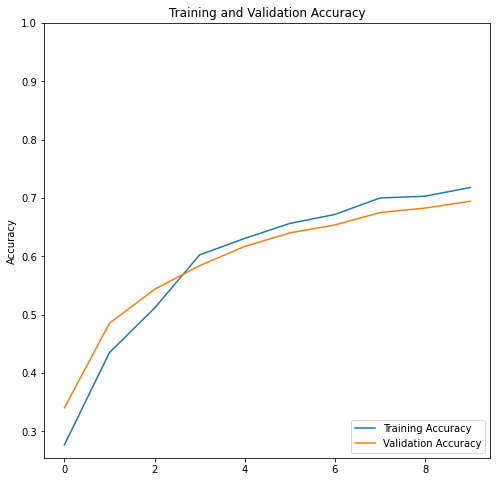

In [23]:
plt.figure(figsize=(8, 8))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.show()

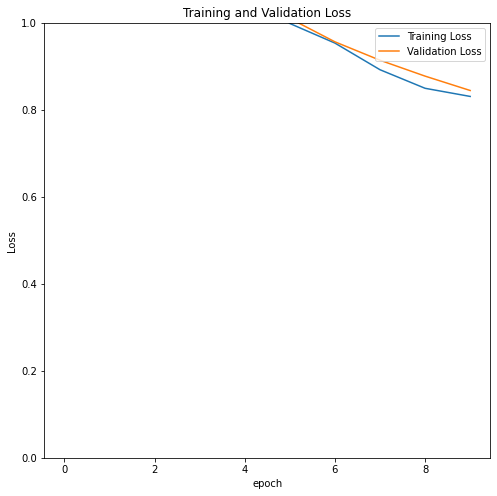

In [24]:
plt.figure(figsize=(8, 8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [25]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [26]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [27]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [28]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 312, 312, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 312, 312, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 312, 312, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 10, 10, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 7686  

In [29]:
len(model.trainable_variables)

56

In [31]:
FINE_TUNE_EPOCHS = 10
TOTAL_EPOCHS =  EPOCHS + FINE_TUNE_EPOCHS

history_fine = model.fit(train_set,
                         epochs=TOTAL_EPOCHS,
                         initial_epoch=history.epoch[-1],
                         validation_data=test_set)

Epoch 10/20
74/74 [==============================] - 67s 901ms/step - loss: 0.3091 - accuracy: 0.8917 - val_loss: 0.3399 - val_accuracy: 0.8723
Epoch 11/20
74/74 [==============================] - 67s 898ms/step - loss: 0.2877 - accuracy: 0.9003 - val_loss: 0.3159 - val_accuracy: 0.8781
Epoch 12/20
74/74 [==============================] - 66s 894ms/step - loss: 0.2653 - accuracy: 0.9042 - val_loss: 0.2706 - val_accuracy: 0.9110
Epoch 13/20
74/74 [==============================] - 66s 905ms/step - loss: 0.2520 - accuracy: 0.9144 - val_loss: 0.2874 - val_accuracy: 0.9052
Epoch 14/20
74/74 [==============================] - 66s 891ms/step - loss: 0.2413 - accuracy: 0.9127 - val_loss: 0.2875 - val_accuracy: 0.9014
Epoch 15/20
74/74 [==============================] - 66s 908ms/step - loss: 0.2307 - accuracy: 0.9234 - val_loss: 0.2810 - val_accuracy: 0.9052
Epoch 16/20
74/74 [==============================] - 66s 890ms/step - loss: 0.2241 - accuracy: 0.9243 - val_loss: 0.2684 - val_accuracy:

In [32]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

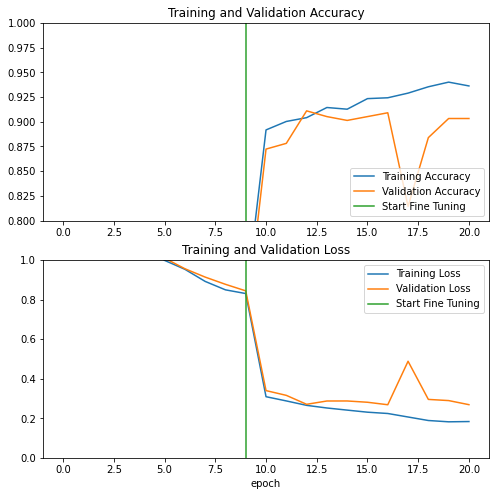

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([EPOCHS-1,EPOCHS-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([EPOCHS-1,EPOCHS-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [34]:
loss, accuracy = model.evaluate(test_set)

17/17 [==============================] - 4s 201ms/step - loss: 0.2688 - accuracy: 0.9033


In [35]:
print('Test loss :', loss)
print('Test accuracy :', accuracy)

Test loss : 0.26877257227897644
Test accuracy : 0.9032881855964661


In [36]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

validation_dataset = image_dataset_from_directory('/content/drive/MyDrive/data/valid',
                                                  shuffle=True,
                                                  batch_size=32,
                                                  image_size=(312,312))

Found 630 files belonging to 6 classes.


In [ ]:
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()

predictions = model.predict_on_batch(image_batch).flatten()

print(predictions)

[9.26289715e-07 9.93421972e-01 3.25915986e-03 1.50299491e-06
 3.29665677e-03 1.97311783e-05 9.99841690e-01 9.23724315e-08
 1.48895497e-05 7.31944237e-05 7.02049533e-07 6.93706970e-05
 1.01833239e-05 1.34205278e-02 1.19696036e-02 7.03710612e-06
 9.72819388e-01 1.77328032e-03 9.88291442e-01 2.58668384e-04
 8.37768603e-05 8.03532638e-03 2.22561276e-03 1.10507139e-03
 4.18541022e-03 8.25969444e-04 8.24002142e-04 9.93252695e-01
 8.97911494e-04 1.40808152e-05 5.61429420e-03 2.91041825e-02
 7.09233582e-01 6.88517932e-03 3.75164337e-02 2.11646333e-01
 4.82261967e-05 9.75156248e-01 4.72796662e-03 6.72334645e-05
 1.96874607e-02 3.12841352e-04 1.94548193e-06 3.19960993e-03
 1.44803780e-04 9.96345989e-07 9.96324360e-01 3.28250171e-04
 8.37580046e-06 7.06478179e-01 6.37783378e-04 9.27711790e-06
 2.92687446e-01 1.79014896e-04 3.48347094e-04 3.95561606e-01
 5.19549549e-01 1.05442456e-03 5.76774813e-02 2.58085299e-02
 1.02037273e-03 2.34369596e-04 9.97495711e-01 8.09607853e-04
 3.32404685e-04 1.074959

In [ ]:
classes = np.argmax(predictions, axis = 1)
print(classes)

AxisError: ignored

(312, 312, 3)
[2]
Maximum Probability:  0.99763465
Classified: metal


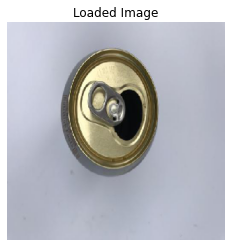

In [60]:
from tensorflow.keras.preprocessing import image

img_path = '/content/drive/MyDrive/data/test/metal32.jpg'

img_V = image.load_img(img_path, target_size=(312,312))
#img = image.img_to_array(img, dtype=np.uint8)
#img = np.array(img)/255.0

img = tf.image.decode_jpeg(tf.io.read_file(img_path),channels=3)

img = tf.image.resize(img,[312, 312])

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img_V)

p = model.predict(img[np.newaxis, ...])
#p = model.predict(img)


print(img.shape)

classes = np.argmax(p, axis = 1)
print(classes)

#print("Predicted shape",p.shape)
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)

In [63]:
model.save('/content/drive/MyDrive/StaZ/mobilenet_model_v1.h5')
print('Model Saved!')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Model Saved!


In [62]:
file = "Mob_Garbage.h5"
tf.keras.models.save_model(model,file)
converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file(file)
tflite_model=converter.convert()
open("Mob_garbage.tflite",'wb').write(tflite_model)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmprtq7wqrs/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from /tmp/tmprtq7wqrs/variables/variables
INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}
INFO:tensorflow:input tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_2
INFO:tensorflow: tensor name: serving_default_input_2:0, shape: (-1, 312, 312, 3), type: DT_FLOAT
INFO:tensorflow:output tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense
INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 6), type: DT_FLOAT
INFO:tensorflow:Restoring parameters from /tmp/tmprtq7wqrs/variables/variables
Instructions for updating:
Use `tf.compat.v1.graph_util.con

8898120


-------------------Individual Probability--------------------------------

CARDBOARD : 1.62 %
GLASS : 4.1 %
METAL : 86.01 %
PAPER : 0.61 %
PLASTIC : 3.67 %
TRASH : 3.99 %


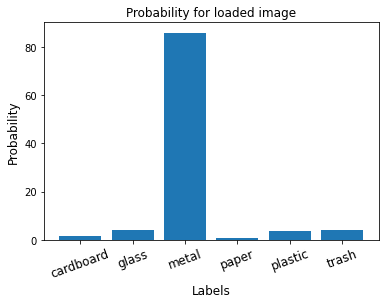

In [ ]:


classes=[]
prob=[]
print("\n-------------------Individual Probability--------------------------------\n")

for i,j in enumerate (p[0],0):
    print(labels[i].upper(),':',round(j*100,2),'%')
    classes.append(labels[i])
    prob.append(round(j*100,2))
    
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(classes))
    plt.bar(index, prob)
    plt.xlabel('Labels', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.xticks(index, classes, fontsize=12, rotation=20)
    plt.title('Probability for loaded image')
    plt.show()
plot_bar_x()



## Accuracy Graph

## Convert to TFlite

In [ ]:
import tensorflow as tf

file = "Garbage.h5"
tf.keras.models.save_model(model,file)
converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file(file)
tflite_model=converter.convert()
open("garbage.tflite",'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpvnwqp90a/assets
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from /tmp/tmpvnwqp90a/variables/variables
INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}
INFO:tensorflow:input tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_input
INFO:tensorflow: tensor name: serving_default_conv2d_input:0, shape: (-1, 312, 312, 3), type: DT_FLOAT
INFO:tensorflow:output tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_1
INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 6), type: DT_FLOAT
INFO:tensorflow:Restoring parameters from /tmp/tmpvnwqp90a/variable

12617040